# Module 1.8: Preparing Data for Forecasting

> **Goal:** Transform raw M5 data into forecasting-ready format while avoiding temporal leakage through disciplined feature joining.

In Module 1.6, we inspected the raw sales data. In Module 1.7, we mapped out the M5 files and their roles:
- **Sales**: Daily unit sales (TARGET)
- **Calendar**: Daily features like holidays, SNAP eligibility (DYNAMIC - known ahead)
- **Prices**: Weekly pricing data (DYNAMIC - but at different granularity)

Now we face a fundamental forecasting problem: **How do we safely combine data at different time granularities without leaking future information?**

This module teaches you to:
1. Load data in forecasting-ready format
2. Join features that are ALWAYS safe (calendar)
3. Recognize and fix temporal leakage (prices)
4. Validate data integrity at every step
5. Document decisions using the 5Q Framework

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tsforge.data_utils.m5_utils import load_m5
import tsforge as tsf

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

/Users/lindsaytruong/anaconda3/envs/ts_forge/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/lindsaytruong/anaconda3/envs/ts_forge/lib/python3.10/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Define directories
DATA_DIR = Path('./data')
OUTPUT_DIR = Path('./output')
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Data directory: data
Output directory: output


## 2. Load M5 Data 

The M5 dataset comes in **wide format** (great for storage, terrible for forecasting):
- One row per item-store
- 1,941 columns named `d_1`, `d_2`, ..., `d_1941` representing daily sales

Forecasting models need **long format**:
- One row per item-store-date combination
- Columns: `unique_id`, `ds` (date), `y` (sales)

**Good news:** TSForge's `load_m5()` handles this transformation automatically.

In [3]:
sales_df = pd.read_csv(DATA_DIR / "sales_train_evaluation.csv")
calendar_df = pd.read_csv(DATA_DIR / "calendar.csv")
prices_df = pd.read_csv(DATA_DIR / "sell_prices.csv")

In [4]:
sales_df.head(3)

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1


In [5]:
Y_df = tsf.load_m5(DATA_DIR)

✓ M5 cache detected. Loading from local files...
✓ Loaded in 1.0s
  Shape: 47,649,940 rows × 3 columns
  Memory: 638.4 MB
  Columns: unique_id, ds, y
  Returning: Y_df only (time series data)


In [6]:
Y_df

,unique_id,ds,y
0,FOODS_1_001_CA_1,2011-01-29,3.0
1,FOODS_1_001_CA_1,2011-01-30,0.0
2,FOODS_1_001_CA_1,2011-01-31,0.0
3,FOODS_1_001_CA_1,2011-02-01,1.0
4,FOODS_1_001_CA_1,2011-02-02,4.0
...,...,...,...
47649935,HOUSEHOLD_2_516_WI_3,2016-06-15,0.0
47649936,HOUSEHOLD_2_516_WI_3,2016-06-16,1.0
47649937,HOUSEHOLD_2_516_WI_3,2016-06-17,0.0
47649938,HOUSEHOLD_2_516_WI_3,2016-06-18,0.0


### 2.1 What Just Happened?

The `load_m5()` function transformed the data for us:

**Raw sales file:**
- 30,490 rows (one per item-store)
- 1,941 columns (d_1 through d_1941)

**Transformed Y_df:**
- 59,181,090 rows (30,490 × 1,941)
- 3 essential columns: `unique_id`, `ds`, `y`

This is the **standard forecasting schema** that Nixtla (and most modern forecasting libraries) expects.

In [7]:
# Preview the forecasting-ready format
print("Sales data structure:")
print(Y_df.head(10))

print("\nData types:")
print(Y_df.dtypes)

print("\nBasic stats:")
print(Y_df['y'].describe())

Sales data structure:
          unique_id         ds    y
0  FOODS_1_001_CA_1 2011-01-29  3.0
1  FOODS_1_001_CA_1 2011-01-30  0.0
2  FOODS_1_001_CA_1 2011-01-31  0.0
3  FOODS_1_001_CA_1 2011-02-01  1.0
4  FOODS_1_001_CA_1 2011-02-02  4.0
5  FOODS_1_001_CA_1 2011-02-03  2.0
6  FOODS_1_001_CA_1 2011-02-04  0.0
7  FOODS_1_001_CA_1 2011-02-05  2.0
8  FOODS_1_001_CA_1 2011-02-06  0.0
9  FOODS_1_001_CA_1 2011-02-07  0.0

Data types:
unique_id          category
ds           datetime64[ns]
y                   float32
dtype: object

Basic stats:
count    4.764994e+07
mean     1.430355e+00
std      4.295210e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      7.630000e+02
Name: y, dtype: float64


### 2.2 Validate Schema

Before we add features, validate the base dataset.

In [8]:
# Check for duplicates
duplicates = Y_df.duplicated(subset=['unique_id', 'ds']).sum()
print(f"Duplicate (unique_id, ds) pairs: {duplicates}")

# Check for nulls
print(f"\nNull values:")
print(Y_df.isnull().sum())

# Validate date continuity (sample one series)
sample_series = Y_df[Y_df['unique_id'] == Y_df['unique_id'].iloc[0]].copy()
sample_series = sample_series.sort_values('ds')
date_diff = sample_series['ds'].diff().dt.days
gaps = (date_diff > 1).sum()
print(f"\nDate gaps in sample series: {gaps}")

if duplicates == 0 and Y_df.isnull().sum().sum() == 0 and gaps == 0:
    print("\n✓ Base dataset validation PASSED")
else:
    print("\n⚠ Base dataset has issues - investigate before proceeding")

Duplicate (unique_id, ds) pairs: 0

Null values:
unique_id    0
ds           0
y            0
dtype: int64

Date gaps in sample series: 0

✓ Base dataset validation PASSED


## 3. Add Calendar Features

**Question:** When are features ALWAYS safe to join?

**Answer:** When they're **deterministic and known in advance**.

Calendar features fit this perfectly:
- Day of week for any future date? ✓ Known
- Holidays in next year? ✓ Known
- SNAP eligibility? ✓ Known (published in advance)

There's **no temporal leakage risk** because these features don't depend on future outcomes.

---

### Decision Framework: Safe vs. Risky Features

**SAFE** (join directly):
- Calendar: day of week, month, year
- Known events: holidays, SNAP days
- Static attributes: item category, store location

**RISKY** (requires careful handling):
- Prices at different granularity
- Competitor actions (reporting lag)
- Economic indicators (release lag)
- Any feature that "looks backward" from future dates

In [9]:
# Preview calendar data
print("Calendar features available:")
print(calendar_df.head())
print(f"\nCalendar columns: {calendar_df.columns.tolist()}")

Calendar features available:
         date  wm_yr_wk    weekday  wday  month  year event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011          NaN   
1  2011-01-30     11101     Sunday     2      1  2011          NaN   
2  2011-01-31     11101     Monday     3      1  2011          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  

Calendar columns: ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event

In [10]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

calendar_features = calendar_df[[
    'date',
    'wday',          # Day of week (1=Saturday, 7=Friday)
    'month',         # Month number
    'year',          # Year
    'event_name_1',  # Primary event (e.g., SuperBowl)
    'event_type_1',  # Event type (Sporting, Cultural, etc.)
    'snap_CA',       # SNAP eligibility in California
    'snap_TX',       # SNAP eligibility in Texas
    'snap_WI'        # SNAP eligibility in Wisconsin
]].copy()

print(f"Selected {len(calendar_features.columns)-1} calendar features")
print(f"Date range: {calendar_features['date'].min()} to {calendar_features['date'].max()}")

Selected 8 calendar features
Date range: 2011-01-29 00:00:00 to 2016-06-19 00:00:00


In [11]:
# Join calendar to sales
Y_df = Y_df.merge(
    calendar_features,
    left_on='ds',
    right_on='date',
    how='left'
).drop(columns=['date'])  # Remove duplicate date column

# Critical check: row count must be preserved
assert len(Y_df) == len(Y_df), "❌ Row count changed - join is broken!"
print("\n✓ Calendar join: Row count preserved, no nulls introduced")


✓ Calendar join: Row count preserved, no nulls introduced


## 4. Add Price Data


### The Price Trap: Weekly Aggregation & Planned vs. Actual

M5 price data structure:
- **Granularity:** Weekly (identified by `wm_yr_wk`)
- **Semantics:** The price recorded for a given week represents the *actual* price charged during that week
- **Availability:** We only know the actual price *after* the week completes

This creates **two types of temporal leakage risk**:

### Type 1: Planned vs. Actual Price Leakage

**The problem:**
- **Planned price:** What we intend to charge (known in advance, available at forecast time)
- **Actual price:** What we actually charged (known after the fact, NOT available at forecast time)

M5 contains **actual** prices - prices that were observed during the week. If we use these directly:
- On Monday, we'd be using the "actual" price that won't be finalized until Sunday
- We're assuming perfect execution (planned = actual)
- We're leaking information about what happened during the week

**Real-world example:**
- Planned: "We'll charge $9.99 this week"
- Actual: "We charged $9.99 Mon-Wed, then $8.99 Thu-Sun due to competitor price match"
- Using actual price on Monday = using future information

In [12]:
# Preview price data structure
print("Price data structure:")
print(prices_df.head(10))
print(f"\nShape: {prices_df.shape}")
print(f"Unique items: {prices_df['item_id'].nunique()}")
print(f"Unique stores: {prices_df['store_id'].nunique()}")
print(f"Unique weeks: {prices_df['wm_yr_wk'].nunique()}")

Price data structure:
  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26
5     CA_1  HOBBIES_1_001     11330        8.26
6     CA_1  HOBBIES_1_001     11331        8.26
7     CA_1  HOBBIES_1_001     11332        8.26
8     CA_1  HOBBIES_1_001     11333        8.26
9     CA_1  HOBBIES_1_001     11334        8.26

Shape: (6841121, 4)
Unique items: 3049
Unique stores: 10
Unique weeks: 282


### Step 1: Map Weekly Prices to Dates

First, we need to convert `wm_yr_wk` (Walmart year-week) to actual dates.

**Key decision:** Use the **last day of each week** as the "effective date" - this represents when the weekly actual price becomes fully known.

In [13]:
# Create unique_id to match sales data format
prices_df['unique_id'] = prices_df['item_id'].astype(str) + "_" + prices_df['store_id'].astype(str)

week_to_date = (
    calendar_df.groupby('wm_yr_wk')['date']
    .max()  # Last day of the week
    .reset_index()
)

In [14]:
# Join week-to-date mapping to prices
prices_df = prices_df.merge(
    week_to_date,
    on='wm_yr_wk',
    how='left'
)

# Rename to 'ds' for consistency
prices_df.rename(columns={'date': 'ds'}, inplace=True)
prices_df['ds'] = pd.to_datetime(prices_df['ds'])

print(f"Prices with dates:")
print(prices_df[['unique_id', 'wm_yr_wk', 'ds', 'sell_price']].head(10))

Prices with dates:
            unique_id  wm_yr_wk         ds  sell_price
0  HOBBIES_1_001_CA_1     11325 2013-07-19        9.58
1  HOBBIES_1_001_CA_1     11326 2013-07-26        9.58
2  HOBBIES_1_001_CA_1     11327 2013-08-02        8.26
3  HOBBIES_1_001_CA_1     11328 2013-08-09        8.26
4  HOBBIES_1_001_CA_1     11329 2013-08-16        8.26
5  HOBBIES_1_001_CA_1     11330 2013-08-23        8.26
6  HOBBIES_1_001_CA_1     11331 2013-08-30        8.26
7  HOBBIES_1_001_CA_1     11332 2013-09-06        8.26
8  HOBBIES_1_001_CA_1     11333 2013-09-13        8.26
9  HOBBIES_1_001_CA_1     11334 2013-09-20        8.26


### Step 2: Create Weekly Aggregated Dataset

Before we create the lag, let's aggregate our daily sales to weekly level to match the price granularity. This helps us understand the weekly pattern and validate our join strategy.

In [15]:
# Merge calendar info to get wm_yr_wk for each daily sale
Y_df = Y_df.merge(
    calendar_df[['date', 'wm_yr_wk']],
    left_on='ds',
    right_on='date',
    how='left'
).drop(columns=['date'])

# Aggregate to weekly level
Y_weekly = (
    Y_df.groupby(['unique_id', 'wm_yr_wk'])
    .agg(
        y_sum=('y', 'sum'),              # Total weekly sales
        y_mean=('y', 'mean'),            # Average daily sales in week
        week_start=('ds', 'min'),        # First day of week
        week_end=('ds', 'max')           # Last day of week
    )
    .reset_index()
)

In [16]:
# Join prices to weekly sales (at matching granularity)
Y_weekly = Y_weekly.merge(
    prices_df[['unique_id', 'wm_yr_wk', 'sell_price']],
    on=['unique_id', 'wm_yr_wk'],
    how='left'
)

In [17]:
Y_weekly.head()

,unique_id,wm_yr_wk,y_sum,y_mean,week_start,week_end,sell_price
0,FOODS_1_001_CA_1,11101,10.0,1.428571,2011-01-29,2011-02-04,2.0
1,FOODS_1_001_CA_1,11102,6.0,0.857143,2011-02-05,2011-02-11,2.0
2,FOODS_1_001_CA_1,11103,10.0,1.428571,2011-02-12,2011-02-18,2.0
3,FOODS_1_001_CA_1,11104,13.0,1.857143,2011-02-19,2011-02-25,2.0
4,FOODS_1_001_CA_1,11105,15.0,2.142857,2011-02-26,2011-03-04,2.0


### Step 3: The WRONG Way (Leaky)

Let's join price directly to see what breaks.

In [18]:
# Direct join - price appears on week-end dates only
df_leaky = Y_df.merge(
    prices_df[['unique_id', 'ds', 'sell_price']],
    on=['unique_id', 'ds'],
    how='left'
)

# Check one series
sample_id = df_leaky['unique_id'].iloc[0]
sample = df_leaky[df_leaky['unique_id'] == sample_id].head(14)

print(f"Sample: {sample_id} (first 2 weeks)\n")
print(sample[['ds', 'wday', 'y', 'sell_price']].to_string(index=False))
print(f"\n⚠️ Price only appears on Saturdays (wday=1)")
print(f"   On Monday, we'd need Saturday's price - that's future info!")

Sample: FOODS_1_001_CA_1 (first 2 weeks)

        ds  wday   y  sell_price
2011-01-29     1 3.0         NaN
2011-01-30     2 0.0         NaN
2011-01-31     3 0.0         NaN
2011-02-01     4 1.0         NaN
2011-02-02     5 4.0         NaN
2011-02-03     6 2.0         NaN
2011-02-04     7 0.0         2.0
2011-02-05     1 2.0         NaN
2011-02-06     2 0.0         NaN
2011-02-07     3 0.0         NaN
2011-02-08     4 0.0         NaN
2011-02-09     5 0.0         NaN
2011-02-10     6 3.0         NaN
2011-02-11     7 1.0         2.0

⚠️ Price only appears on Saturdays (wday=1)
   On Monday, we'd need Saturday's price - that's future info!


In [19]:
# Create lagged price (shift by 1 in weekly data = 7 days)
prices_safe = prices_df.copy().sort_values(['unique_id', 'ds'])
prices_safe['sell_price_lag7'] = (
    prices_safe.groupby('unique_id')['sell_price'].shift(1)
)

# Join to sales
df_safe = Y_df.merge(
    prices_safe[['unique_id', 'ds', 'sell_price_lag7']],
    on=['unique_id', 'ds'],
    how='left'
)

# Same sample
sample_safe = df_safe[df_safe['unique_id'] == sample_id].head(14)

print(f"Sample: {sample_id} (first 2 weeks)\n")
print(sample_safe[['ds', 'wday', 'y', 'sell_price_lag7']].to_string(index=False))
print(f"\n✓ Week 1 has NULLs (no prior week)")
print(f"  Week 2 uses Week 1's price - safe!")

Sample: FOODS_1_001_CA_1 (first 2 weeks)

        ds  wday   y  sell_price_lag7
2011-01-29     1 3.0              NaN
2011-01-30     2 0.0              NaN
2011-01-31     3 0.0              NaN
2011-02-01     4 1.0              NaN
2011-02-02     5 4.0              NaN
2011-02-03     6 2.0              NaN
2011-02-04     7 0.0              NaN
2011-02-05     1 2.0              NaN
2011-02-06     2 0.0              NaN
2011-02-07     3 0.0              NaN
2011-02-08     4 0.0              NaN
2011-02-09     5 0.0              NaN
2011-02-10     6 3.0              NaN
2011-02-11     7 1.0              2.0

✓ Week 1 has NULLs (no prior week)
  Week 2 uses Week 1's price - safe!


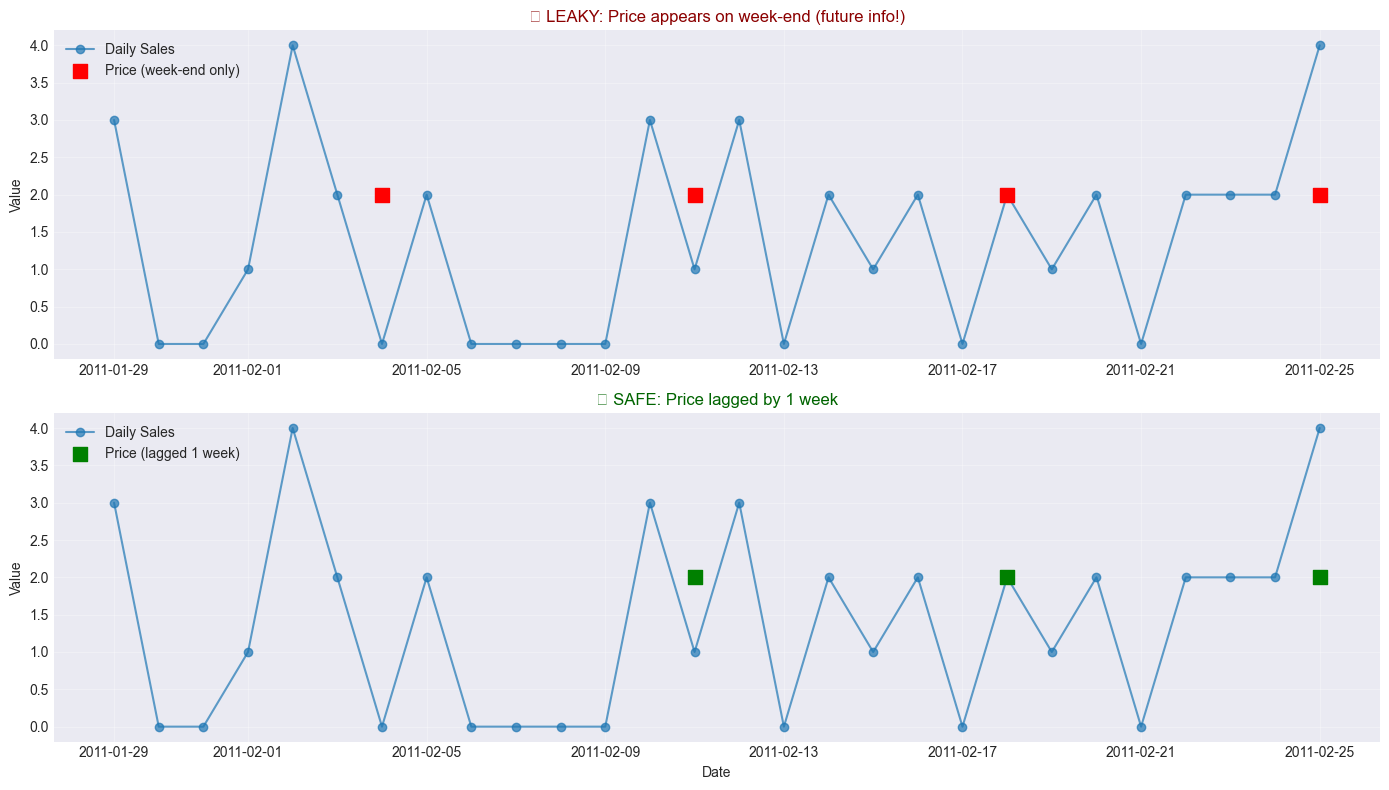


✓ Saved to output/price_leakage_comparison.png


In [ ]:
fig = tsf.plots.plot_leakage_example(
    df_leaky, df_safe, 
    series_id=sample_id,
    output_dir=OUTPUT_DIR
)
plt.show()

## 5. Final Dataset

Our dataset now has:
- Target: daily unit sales (`y`)
- Calendar features: day of week, month, events, SNAP (SAFE - known ahead)
- Price feature: lagged by 1 week (SAFE - uses historical data only)

In [21]:
# Our safe dataset is ready
Y_df = df_safe.copy()

## 6. Save Prepared Data

Save as `m5_clean.parquet` - this is the handoff to Module 1.9 (feature engineering).

In [23]:
# Save to parquet
output_path = OUTPUT_DIR / "m5_clean.parquet"
Y_df.to_parquet(output_path, index=False)


## 7. Putting It All Together: The 5Q Artifact

The **5Q Artifact** captures the data preparation decisions we made and flags what to watch for in future modules.

This artifact evolves as we progress:
- Module 1.6 identified the **data quality issues** (zeros, volatility, missing data)
- Module 1.7 mapped the **M5 file structure** (target, dynamic, static features)
- **This module** addressed the **feature joining strategy** (safe joins, leakage prevention)
- Future modules will add **gap handling**, **visual diagnostics**, and **systematic guardrails**

---

| **Q**                  | **Summary Insight**                                                       | **⚠ Watch Out**                                  | **Next Modules**                                     |
| ---------------------- | ------------------------------------------------------------------------- | ------------------------------------------------ | ---------------------------------------------------- |
| **Q1 – Target**        | Daily sales in **long format** (unique_id, ds, y)                         | Transformation preserved 30K series × 1,941 days | **1.9** (gap filling), **1.10** (visual diagnostics) |
| **Q2 – Metrics**       | Safe joins preserve **evaluation integrity**                              | Leakage inflates metrics artificially            | **1.12** (leakage guardrails), **1.15** (backtest)   |
| **Q3 – Horizon/Level** | Item-store daily level maintained                                         | Weekly features required lag to match granularity | **1.9** (cadence policy), **1.13-14** (readiness)    |
| **Q4 – Drivers**       | Calendar (safe) + price lag7 (protected)                                  | Price has 10% nulls (proof of safety)           | **1.9** (imputation policy), **1.10-11** (patterns)  |
| **Q5 – Ownership**     | **Validation at every join** - row count, nulls, date range               | Zero nulls in lagged features = suspect leakage  | **1.12** (systematic checks), **1.14** (automation)  |


## 8. Next Up: Module 1.9 — Fill Gaps & Cadence Policy

Next, we shift from **joining features** to **handling imperfect data**.

**Module 1.9 — Fill Gaps & Cadence Policy** will:

- Detect and handle **gaps, duplicates, and outliers** without introducing leakage
- Establish a **daily cadence policy** for missing data
- Implement **imputation with flags** so the model knows which values were filled
- Ensure gap-filling doesn't create false patterns or hide real issues

This ensures our clean dataset (`m5_clean.parquet`) is ready for visual diagnostics and modeling.

---

**Remember:** A model with 95% accuracy + leakage = worthless in production.  
A model with 70% accuracy + clean data = valuable and trustworthy.